In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='mako')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

In [4]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [5]:
RANDOM = 42

# LOADING DATA

In [6]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

In [7]:
cargotype_info

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует выво..."
4,990.0,Потребует обязательной маркировки в ближайшем ...
5,910.0,интим товар
6,900.0,медикаменты
7,10.0,документы и ценные бумаги
8,50.0,предметы искусства
9,100.0,товары народного потребления


In [8]:
data.sample(5)

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
35394,0,5d55d0d69822540136d4148dad292ed1,YMW,1,YME,YMW,18000,YME,1855,40050,0.960,7e0e5a113db0f4e2030f2e84e49739b8,347bdc6f6b2e1771b30a8f324bc7e380,a3c5065fb7f2d247fc5ee11d26e357d1
61658,0,a9f8893a1db3e5168644a33c07d5b609,YME,2,YMX,YME,40050,YMX,3313,46800,1.000,f21897bc48f828e1d4e9c504b5e36ed4,3c1ce2ca41035e7dae93b81e51fc7409,6051edf566629ca0ceb6cdb61cca187c
238954,3,6677d2259ea53009ae1178d849375768,YMF,1,YMF,YMF,13500,YMF,1024,13500,0.310,b096d74a661282e10366b8b15a42ee1c,91037282f41efc9018e939026e68995e,e60755eeebf78b03362ae42cdc3a3a0d
259089,3,a8f3305b4cbb31d1b472099e275f3b43,MYB,1,YMA,MYB,3449,YMA,143,3267,0.025,d01a75ff7a53138af10dc54ec0d09bde,84158e0e6a127eb6cccc87d9e2bda694,2338224652d344e1951f86470fd875a9
138679,0,842171ef3972f81165a5defc615a8717,YMG,1,YME,YMG,26820,YME,6290,40050,0.350,635b3f49f882b8fb3c358308cb833701,da0ee94de3d7ae04c50fe0b8a569c3d7,e209266db6d09b7c898574508d83b9ad


In [9]:
data.query('pack_volume > sel_calc_cube')

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325608,7,49a255ef0fa15f30c54251d9e386e480,NONPACK,4,NONPACK,NONPACK,0,NONPACK,1617,0,0.43,29dbb42befa2f176eb50828deba50afc,ce21d9ab9bf6770610560ee7f6ec6602,2152f99eb6f0a15bd602e409c83591f9
325615,7,3c65842e3a1e1295cb4a5d24f6fd000f,NONPACK,2,NONPACK,NONPACK,0,NONPACK,16200,0,1.70,7b2a05c04b90c4360617bc280d8454b4,ce21d9ab9bf6770610560ee7f6ec6602,fc006d1b3e836628df7990375de8ec4a
325616,7,8ed0af8473526c54b4b2f99f0060c3ea,NONPACK,1,YML,NONPACK,0,YML,25168,104586,1.26,036724225d7ff6f662afcbf909423c30,eeafb158c529eaf1aa9b8f2068a82914,a1882fe810b0e3dc939f87b20264a3fa
325617,7,8ed0af8473526c54b4b2f99f0060c3ea,NONPACK,1,YML,NONPACK,0,YML,25168,104586,1.26,036724225d7ff6f662afcbf909423c30,eeafb158c529eaf1aa9b8f2068a82914,a1882fe810b0e3dc939f87b20264a3fa


In [10]:
sku.isna().sum()

sku    0
a      0
b      0
c      0
dtype: int64

<Axes: >

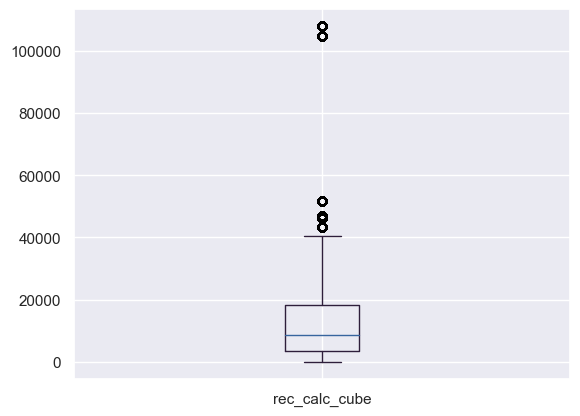

In [11]:
data['rec_calc_cube'].plot(kind='box')

<Axes: >

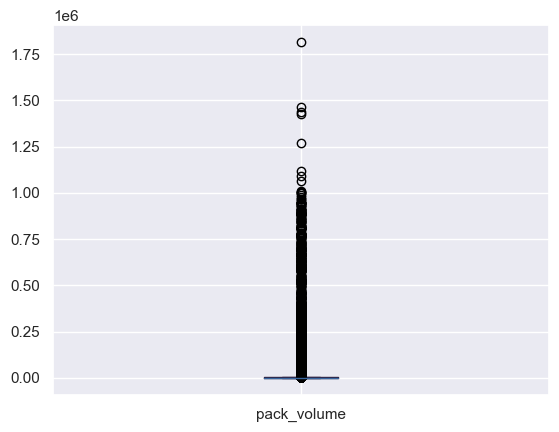

In [12]:
data['pack_volume'].plot(kind='box')

In [13]:
mb_not_important = [690, 691, 692, 931, 930, 350, 920, 292, 291, 290, 303, 302, 110, 752, 751, 410, 799, 20, 400, 0, 780, 760, 510, 150, 790, 950, 990, 985, 301]

In [14]:
carton_price.columns = ['cartontype', 'price']

In [15]:
carton.columns = [s.lower() for s in carton.columns]

In [16]:
data[['sku', 'selected_cartontype']]

,sku,selected_cartontype
0,af49bf330e2cf16e44f0be1bdfe337bd,NONPACK
1,af49bf330e2cf16e44f0be1bdfe337bd,NONPACK
2,af49bf330e2cf16e44f0be1bdfe337bd,NONPACK
3,af49bf330e2cf16e44f0be1bdfe337bd,NONPACK
4,af49bf330e2cf16e44f0be1bdfe337bd,NONPACK
...,...,...
325618,86dcc1a44eb2939fea4d2dd3604e1f9e,MYC
325619,86dcc1a44eb2939fea4d2dd3604e1f9e,MYC
325620,9db21acf9e6c1a66493c246c1461f989,YMC
325621,4aedb72c5662562524f6119918c7179b,MYB


In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [18]:
corr_test = pd.merge(sku_cargotypes, data[['sku', 'selected_cartontype']], on='sku', how='left')

In [19]:
corr_test['selected_cartontype'] = label_encoder.fit_transform(corr_test['selected_cartontype'])

In [20]:
corr_test['selected_cartontype'].value_counts()

selected_cartontype
17    20719751
1       238549
2       214144
10      133978
13      119352
6       113453
3       103663
15       94872
12       93005
0        84781
8        77057
11       65961
7        55215
4        38970
14       16736
5         6299
16        3955
9            6
Name: count, dtype: int64

In [21]:
corr_test[['cargotype', 'selected_cartontype']].corr() # корреляция категория тип упаковки

,cargotype,selected_cartontype
cargotype,1.000000,0.021945
selected_cartontype,0.021945,1.000000


In [22]:
sku_cargotypes.head()

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290


In [23]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype not in @mb_not_important') # дропаем как мне кажется не особо важные
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
#sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left') # 
sku_groups.head()

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[310.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[600.0, 610.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[440.0, 441.0, 480.0, 490.0, 520.0]"


In [24]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

In [25]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')
carton = gen_geometry_feat(carton, 'length', 'width', 'height')

In [26]:
sku

,sku,a,b,c,dim_sum,vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0,70.0,9548.0,23.0,28.0,341.0,308.0,868.0,308.0,505.0,43.2
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0,83.0,16240.0,27.0,29.0,406.0,1160.0,560.0,406.0,708.0,51.4
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,60.0,5460.0,20.0,13.0,156.0,420.0,455.0,156.0,343.0,39.2
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0,24.0,312.0,8.0,8.0,39.0,24.0,104.0,24.0,55.0,15.6
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0,170.0,96768.0,56.0,56.0,1728.0,5376.0,1008.0,1008.0,2704.0,112.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385956,5367045e88650a12cde4803f55ed7525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6385957,8a3dcb8f1ccce02a3df63a9db0903f38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6385958,31e5069a999cd927bd623fd699957630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6385959,888059750dcd75922faf3b60144e4def,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
non_volume = ['KSD', 'NONPACK', 'STRETCH'] # нулевой объем помешает потом

In [28]:
# фичи для упаковок, для сравнения с фичами заказа
new_carton = carton.query('cartontype not in @non_volume').set_index('cartontype').unstack().reset_index()
new_carton = new_carton.rename(columns={
    'level_0': 'carton_dim',
    0: 'value'
})

new_carton['carton_type_dim'] = new_carton['carton_dim'] + '_' + new_carton['cartontype']
new_carton = new_carton.drop(['carton_dim', 'cartontype'], axis=1)
new_carton_t =  new_carton.set_index('carton_type_dim').T

In [29]:
df = data.copy()

In [30]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [31]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd


In [32]:
#df = df.drop_duplicates().reset_index(drop=True)
df.shape

(325623, 7)

In [33]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd
...,...,...,...,...,...,...,...
325618,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e
325619,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e
325620,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989
325621,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b


In [34]:
# не хватает оперативки

# mlb = MultiLabelBinarizer()
# one_hot = mlb.fit_transform(sku_groups['cargotype'])

# one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
# one_hot_df['sku'] = sku_groups['sku']
# df = pd.merge(df, one_hot_df, on='sku', how='left')

In [35]:
sku = sku[sku['vol']>0]

In [36]:
sku = sku.query('a*b*c != 0')

In [37]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4


In [38]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
sku_a              10899
sku_b              10899
sku_c              10899
dim_sum            10899
sku_vol            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [39]:
df = df.dropna()
df = df.query('goods_wght!=0')

In [40]:
df_sum = df.groupby('orderkey', sort=False).sum() # суммируем по заказам

In [41]:
df_sum = df_sum.drop(['selected_carton', 'sku'], axis=1)

In [42]:
df_sum

,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
orderkey,,,,,,,,,,,,,,,,,
d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4
4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2
3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7
7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2
097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2
0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0
e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9


In [43]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [44]:
# добавляем размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
#df = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_max_diag']], on='orderkey', how='left')

In [45]:
df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']]

,orderkey,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,53.2
2,3e646181f6f708edd3326c1626c12d23,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,43.7
3,7047c16a6b7c120162ca3da0ebca43fd,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,47.2
4,097917e584151c0c21f205b2c3aafa10,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,42.0
...,...,...,...,...,...,...,...,...,...,...
151939,8ed0af8473526c54b4b2f99f0060c3ea,101.0,33.666667,25168.000,1.0,3.4,1.0,0.5,28.6,63.6
151940,0e4f34db53e37d6bf171c2e055e2b4e0,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,33.0
151941,e71d2e750ce9a7a39c273c634be1665d,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,33.9
151942,2e2a642f611b5a6f2c404ab945fbc2a3,37.0,12.333333,552.000,1.0,11.5,1.9,4.2,10.0,26.0


In [46]:
# items = df.groupby('orderkey')['sku'].count().reset_index()
# items.columns = ['orderkey', 'items']
df = pd.merge(df, df_grouped, on='orderkey', how='left')

In [47]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght_x,sku,sku_a_x,sku_b_x,sku_c_x,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,sku_a_y,sku_b_y,sku_c_y,goods_wght_y,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.100,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.100,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.100,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.100,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.100,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314691,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0,26.0,20.0,4.0,0.100,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,33.0
314692,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0,26.0,20.0,4.0,0.100,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,33.0
314693,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,11.4,10.2,30.3,0.284,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,33.9
314694,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0,23.0,2.0,12.0,0.230,37.0,12.333333,552.000,1.0,11.5,1.9,4.2,10.0,26.0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314696 entries, 0 to 314695
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   orderkey         314696 non-null  object 
 1   box_num          314696 non-null  int64  
 2   selected_carton  314696 non-null  object 
 3   sel_calc_cube    314696 non-null  int64  
 4   pack_volume      314696 non-null  int64  
 5   goods_wght_x     314696 non-null  float64
 6   sku              314696 non-null  object 
 7   sku_a_x          314696 non-null  float64
 8   sku_b_x          314696 non-null  float64
 9   sku_c_x          314696 non-null  float64
 10  dim_sum          314696 non-null  float64
 11  sku_vol          314696 non-null  float64
 12  dim_mean         314696 non-null  float64
 13  dim_median       314696 non-null  float64
 14  prod_a_b         314696 non-null  float64
 15  prod_a_c         314696 non-null  float64
 16  prod_b_c         314696 non-null  floa

In [ ]:
# df = df_sum.dropna().reset_index(drop=True)
#df = df[df['selected_carton']!='YMB']
# df[df['selected_carton'] =='YMB']

In [ ]:
# создаем столбцы с размерами коробок пока объем и диагонали(feature_importance считает что они важны)
df[new_carton_t.filter(like='vol').columns.tolist()] = new_carton_t[new_carton_t.filter(like='vol').columns.tolist()].values.reshape(-1,1).flatten().tolist()
df[new_carton_t.filter(like='diag').columns.tolist()] = new_carton_t[new_carton_t.filter(like='diag').columns.tolist()].values.reshape(-1,1).flatten().tolist()

In [49]:
df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght_x,sku,sku_a_x,sku_b_x,sku_c_x,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,sku_a_y,sku_b_y,sku_c_y,goods_wght_y,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.1,48.0,16.0,2046.0,2.8,5.2,1.0,0.5,3.2,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.1,48.0,16.0,2046.0,2.8,5.2,1.0,0.5,3.2,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4,11.0,6.0,31.0,0.1,48.0,16.0,2046.0,2.8,5.2,1.0,0.5,3.2,33.4


In [ ]:
# hard code
def diff(row):
    '''
    отношение диагонали к каждой из диагоналей всех коробок
    '''
    return row['diag'] / row[new_carton_t.filter(like='diag').columns.tolist()]


df[new_carton_t.filter(like='diag').columns.tolist()] = df.apply(diff, axis=1)

In [ ]:
def diff(row):
    '''
    отношение объема к каждой из диагоналей всех коробок
    '''
    return row['sku_vol'] / row[new_carton_t.filter(like='vol').columns.tolist()]


df[new_carton_t.filter(like='vol').columns.tolist()] = df.apply(diff, axis=1)

In [ ]:
df = df.drop('orderkey', axis=1)

In [ ]:
df

In [ ]:
df['sku_vol'].plot(kind='box')

In [ ]:
# дроп выбросов по объему
q1 = df['sku_vol'].quantile(0.25)
q3 = df['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df[(df['sku_vol'] >= lower_bound) & (df['sku_vol'] <= upper_bound)]

In [ ]:
# для категорий товаров
# df.describe()
# cols_zero_max = df.describe().columns[df.describe().loc['max'] == 0]
# cols_zero_max
# df = df.drop(cols_zero_max, axis=1)

In [ ]:
numeric_columns = df.loc[:,df.dtypes!=np.object_].columns

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

In [ ]:
corr_feat = set()
corr_matrix = df_no_outlier_vol.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

In [ ]:
fltr_nonpack =  ["STRETCH", "NONPACK"]

In [ ]:
df_no_outlier_vol_nonpack = df_no_outlier_vol.query('selected_carton not in @fltr_nonpack')

In [ ]:
df_no_outlier_vol_nonpack

In [ ]:
# Проверить
df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

# Модель

In [ ]:
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
df_no_outlier_vol_nonpack.head()

In [ ]:
df_no_outlier_vol_nonpack = df_no_outlier_vol_nonpack.query('selected_carton != "YMB"')

In [ ]:
X = df_no_outlier_vol_nonpack.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol_nonpack['selected_carton']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    #stratify=df['selected_carton']
                                                    )

In [ ]:
y_train.value_counts()

In [ ]:
sm = SMOTE(random_state=RANDOM, k_neighbors = 3)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# для нейронки
# from sklearn.preprocessing import LabelEncoder
# # Создаем объект LabelEncoder
# label_encoder = LabelEncoder()

# # Преобразуем столбец с классами в числа
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

In [ ]:
print(f'TRAIN ACC: {accuracy_score(y_train, pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, preds)}')

In [ ]:
f1_score(y_test, preds, average='weighted')

In [ ]:
print(classification_report(y_test, preds))

TREE

In [ ]:
from tensorflow.keras import Sequential

In [ ]:
import keras
from tensorflow.keras import layers, callbacks

In [ ]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM
from keras.metrics import BinaryAccuracy, AUC

from keras.models import Sequential
#from tensorflow import keras
from keras.layers import Dense, SimpleRNN, Activation, Conv1D, Flatten, MaxPooling1D, Dropout
from keras import optimizers

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(X_train.shape[1]*10, activation='relu', input_shape=[X_train.shape[1]]),
    
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1], activation='relu'),    
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1]//8, activation='relu'),
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1]//16, activation='relu'),    
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1]//32, activation='relu'),
    layers.Dense(1, activation='relu'),
    #layers.Activation('sigmoid')
])

adam = optimizers.Adam(learning_rate=0.0001) #  0.0001 'optimizer': ['adadelta', 'rmsprop', 'adam'] learning_rate = 0.00001

model.compile(
    optimizer=adam,
    #optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
y_train[:5]

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=640,
    epochs=5000,
    verbose=1,
    callbacks=[early_stopping],
)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=36)),
    ('tree', KNeighborsClassifier(n_neighbors=8, p=1)),

    
    # ('tree', CatBoostClassifier(
    #     #learning_rate=0.01, 
    #     #leaf_estimation_method='Gradient',
    #     #n_estimators=1000,
    #     #subsample=0.1,
    #     #max_depth=4,
    #     verbose=100,
    #     #l2_leaf_reg = 7,
    #     #bootstrap_type="Bernoulli",
    #     #class_weights='Balanced',#[1, 1, 1],
    #     loss_function='MultiClass',
    #     eval_metric='TotalF1'
    #     ))
])
# params = {
#     'leaf_estimation_method': 'Gradient',
#     'learning_rate': 0.01,
#     'max_depth': 8,
#     'bootstrap_type': 'Bernoulli',
#     'objective': 'MultiClass',
#     'subsample': 0.8,
#     'random_state': 42,
#     'verbose': 0,
#     "eval_metric" : 'TotalF1',
#     "early_stopping_rounds" : 100
#     }
tree_pipe.fit(X_train, y_train)#X_train_res, y_train_res
#tree_pipe.fit(X_train_res, y_train_res)#

In [ ]:

feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
tree_pipe.named_steps['tree'].get_feature_importance()

In [ ]:
tree_preds = tree_pipe.predict(X_test)

In [ ]:
tree_pred_proba = tree_pipe.predict_proba(X_test)

tree_pred_proba[1]

In [ ]:
tree_pipe.classes_

In [ ]:
print(f'TRAIN ACC: {accuracy_score(y_train, tree_pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')

In [ ]:
f1_score(y_test, tree_preds, average='weighted')

In [ ]:
print(classification_report(y_test, tree_preds))